In [ ]:
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import seaborn as sns
from tqdm import tqdm
from scipy.signal import find_peaks
import mplfinance as mpf

In [93]:
# Loading  the CSV
file_path = 'ES_1hour_sample.csv'
df = pd.read_csv(file_path)

# Displaying the first and last few rows to see its structure
print(df.head())
print(df.tail())

# Extract the close prices as the target variable
prices = df['close'].values

# Preparing data function with all features
def prepare_data_with_features(df, window_size):
    X = []
    y = []
    
    features = ['open', 'high', 'low', 'close', 'volume']
    
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)  # Features: window_size rows of data
        y.append(df['close'].iloc[i+window_size])  # Target: next close price
    
    return np.array(X), np.array(y)

# training size is half of the list.
train_size = int(len(prices) * 0.5)
train_prices = prices[:train_size]
test_prices = prices[train_size:]

# Preparing data
window_size = 50  # Reduced window size to minimize data in computations
X_train, y_train = prepare_data_with_features(df[:train_size], window_size)
X_test, y_test = prepare_data_with_features(df[train_size:], window_size)

# Normalizing data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Converting data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Creating DataLoader for batch processing
batch_size = 32  # Reduced batch size for less memory usage
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Defining the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Add dropout layer
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        pred = self.fc(self.dropout(hn[-1]))  # Apply dropout before fully connected layer
        return pred

# Instantiating the model
model = LSTMModel(input_size=5, hidden_layer_size=64, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Defineing the model prediction function for SHAP
def model_predict(X):
    # Ensuring that the model is in evaluation mode
    model.eval()
    # Making the predictions
    with torch.no_grad():
        # Ensure the input has the correct shape (batch_size, window_size, num_features)
        X_tensor = torch.tensor(X.reshape(-1, window_size, 5), dtype=torch.float32)  # Reshape to (batch_size, window_size, 5)
        y_pred = model(X_tensor)
    # Return as a numpy array for SHAP with shape (batch_size,)
    return y_pred.detach().numpy().flatten()  # Use .flatten() to return a 1D array

# Training the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0 
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)
        
        # Computing the loss
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()  # Backpropagation
        optimizer.step()  # Updating model parameters

    # Printing the learning rate and loss for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss / len(train_loader)}")

# Generating feature names for each step
reshaped_feature_names = []
for t in range(1, window_size + 1):
    for feature in ['open', 'high', 'low', 'close', 'volume']:
        reshaped_feature_names.append(f"{feature}_{t}")  # Add time step index to the feature name

# Flattening the data to feed into k-means clustering (combine window_size and num_features)
reshaped_X_train_flat = X_train_scaled.reshape(-1, window_size * 5)

# Check for the shape
print("Flattened X_train shape:", reshaped_X_train_flat.shape)

# Generating background data using k-means clustering on the data
background_data_kmeans = shap.kmeans(reshaped_X_train_flat, 3)

# Checking the shape of k-means background data
print("Background data shape from k-means:", background_data_kmeans.data.shape)

# Flattening the background data to have shape (3, 50) instead of (3, 5, 10)
background_data_reshaped = background_data_kmeans.data.reshape(3, window_size * 5)

# Checking the shape of reshaped data
print("Reshaped background data shape:", background_data_reshaped.shape)

# Reshaping the test data to 2D array: (test_samples, window_size * num_features)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], window_size * 5)

# Checking reshaped test data shape
print("Reshaped test data shape:", X_test_flat.shape)



             timestamp     open     high      low    close  volume
0  2025-03-02 18:00:00  5967.50  5984.50  5964.25  5974.25   24096
1  2025-03-02 19:00:00  5974.50  5975.75  5947.00  5955.25   23919
2  2025-03-02 20:00:00  5955.25  5966.75  5951.50  5965.25   14393
3  2025-03-02 21:00:00  5965.25  5969.00  5959.75  5964.25    8750
4  2025-03-02 22:00:00  5964.25  5965.50  5957.50  5965.00    7737
               timestamp     open     high      low    close  volume
248  2025-03-17 12:00:00  5700.25  5714.50  5694.50  5707.75   63831
249  2025-03-17 13:00:00  5708.00  5736.50  5701.00  5733.50   67361
250  2025-03-17 14:00:00  5733.50  5759.75  5733.25  5754.50   80243
251  2025-03-17 15:00:00  5754.25  5755.75  5730.50  5732.75  147001
252  2025-03-17 16:00:00  5732.50  5733.75  5725.75  5731.75   41210
Epoch 1/20, Train Loss: 0.21682182451089224
Epoch 2/20, Train Loss: 0.16998683164517084
Epoch 3/20, Train Loss: 0.13479196528593698
Epoch 4/20, Train Loss: 0.0975179597735405
Epoch 5/2

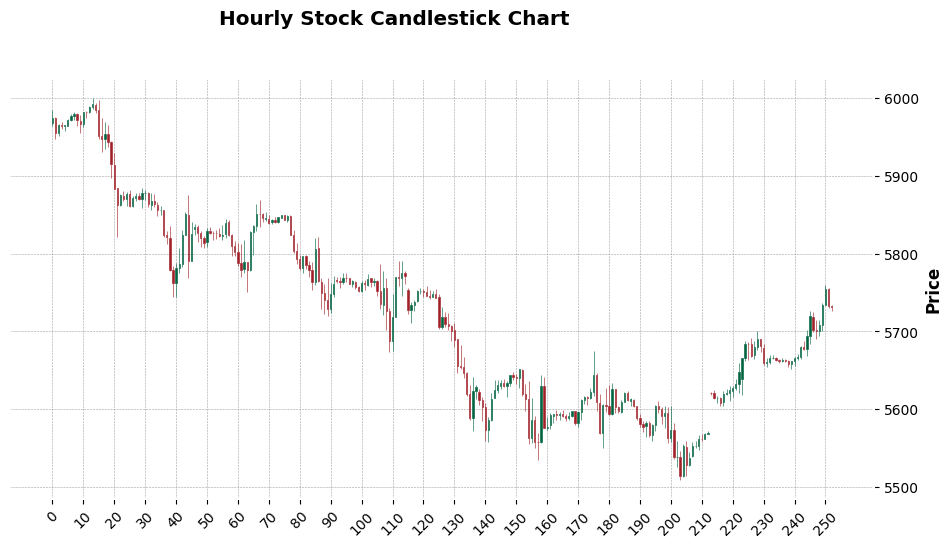

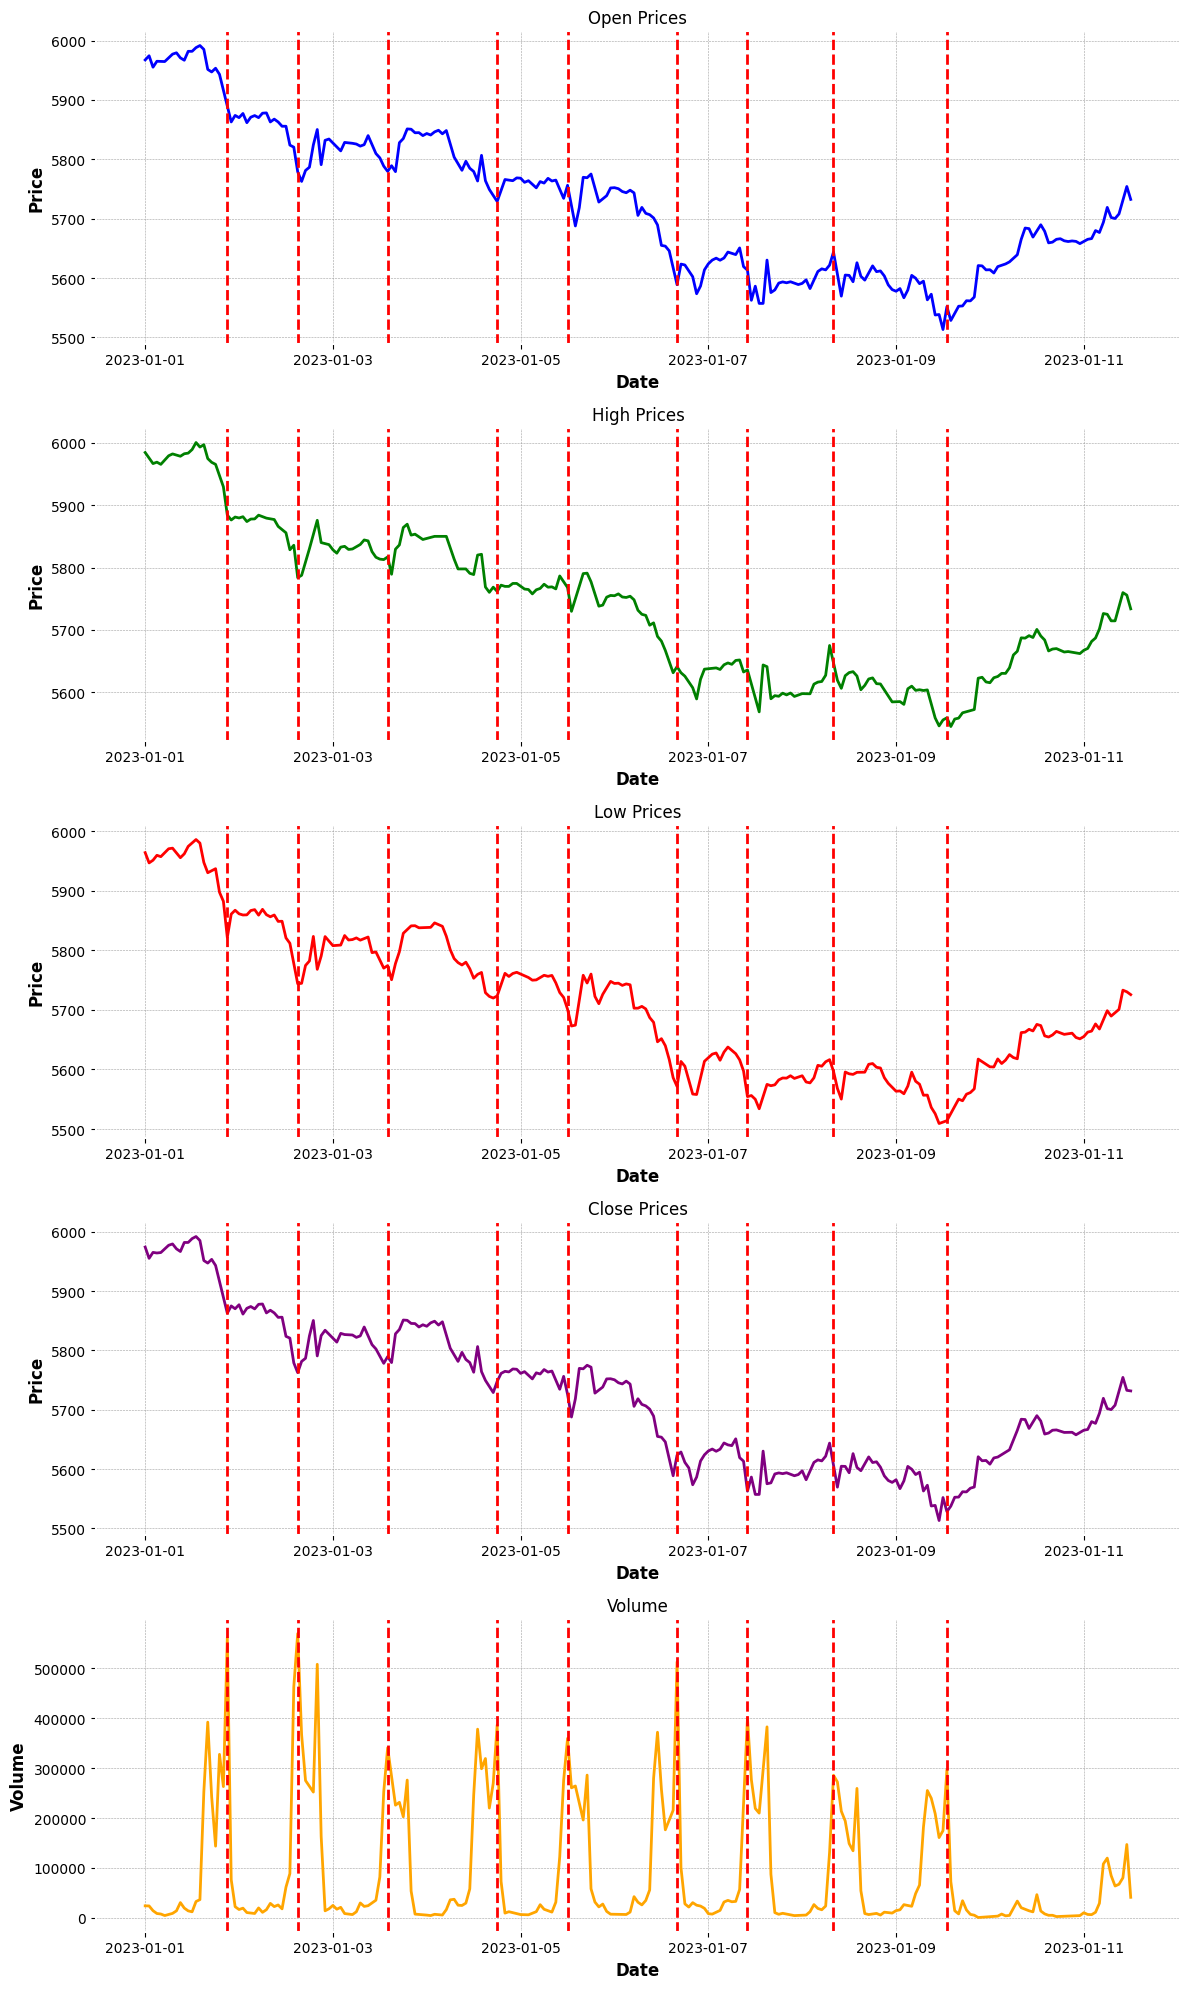

In [95]:
# Creating a datetime index based on fixed start date and hourly frequency
df['datetime'] = pd.date_range(start='2023-01-01', periods=len(df), freq='H')

# Set 'datetime' as the index
df.set_index('datetime', inplace=True)

# Creating a custom style for the chart
s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 10})

# Plotting the candlestick chart
fig, axes = mpf.plot(df, type='candle', style=s, title='Hourly Stock Candlestick Chart',
                     ylabel='Price', ylabel_lower='Volume', figsize=(12, 6), returnfig=True)

# Customizing the hours index to integers)
ax = axes[0]
ticks = range(0, len(df), 10) # steps of 10
ax.set_xticks(ticks)

# Manually set x-tick labels as hour indices (number of hours since the start)
hour_labels = [str(i) for i in ticks]
ax.set_xticklabels(hour_labels)

# 5 individual feature plots
fig, axs = plt.subplots(5, 1, figsize=(12, 20))

# Finding all peaks of volume using find_peaks
peaks, _ = find_peaks(df['volume'])

# Filtering peaks where the volume is greater than 200,000 (to eliminate local maxima)
filtered_peaks = [peak for peak in peaks if df['volume'][peak] > 200000]

# Group adjacent peaks that are close to each other, keeping only the highest one in each group
threshold = 10  # how many indices apart peaks should be to be considered adjacent
grouped_peaks = []

for i, peak in enumerate(filtered_peaks):
    if i == 0:  # First peak, add it to the group
        grouped_peaks.append(peak)
    else:
        # Check if the current peak is within the threshold distance from the previous one
        if peak - filtered_peaks[i-1] <= threshold:
            # If close enough: group the current peak with the previous one
            # only add the peak with the highest volume in the group
            if df['volume'][peak] > df['volume'][grouped_peaks[-1]]:
                grouped_peaks[-1] = peak
        else:
            # If the peak is not close enough, add a new group
            grouped_peaks.append(peak)

# Plotting 'Open' feature
axs[0].plot(df.index, df['open'], color='blue', label='Open')
axs[0].set_title('Open Prices')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].grid(True)
for peak in grouped_peaks:
    axs[0].axvline(x=df.index[peak], color='red', linestyle='--', label="Peak Volume")  # Vertical line at peak volume

# Plotting 'High' feature
axs[1].plot(df.index, df['high'], color='green', label='High')
axs[1].set_title('High Prices')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].grid(True)
for peak in grouped_peaks:
    axs[1].axvline(x=df.index[peak], color='red', linestyle='--', label="Peak Volume")  # Vertical line at peak volume

# Plotting 'Low' feature
axs[2].plot(df.index, df['low'], color='red', label='Low')
axs[2].set_title('Low Prices')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].grid(True)
for peak in grouped_peaks:
    axs[2].axvline(x=df.index[peak], color='red', linestyle='--', label="Peak Volume")  # Vertical line at peak volume

# Plotting 'Close' feature
axs[3].plot(df.index, df['close'], color='purple', label='Close')
axs[3].set_title('Close Prices')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Price')
axs[3].grid(True)
for peak in grouped_peaks:
    axs[3].axvline(x=df.index[peak], color='red', linestyle='--', label="Peak Volume")  # Vertical line at peak volume

# Plotting 'Volume' feature
axs[4].plot(df.index, df['volume'], color='orange', label='Volume')
axs[4].set_title('Volume')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Volume')
axs[4].grid(True)
for peak in grouped_peaks:
    axs[4].axvline(x=df.index[peak], color='red', linestyle='--', label="Peak Volume")  # Vertical line at peak volume

# tigter the layout
plt.tight_layout()
plt.show()


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:30<00:00,  1.17s/it]


New SHAP values shape: (77, 250)
New reshaped SHAP values shape: (77, 50, 5)
New grouped SHAP values shape: (77, 5)
X_subset_features shape (for multiple samples): (77, 5)


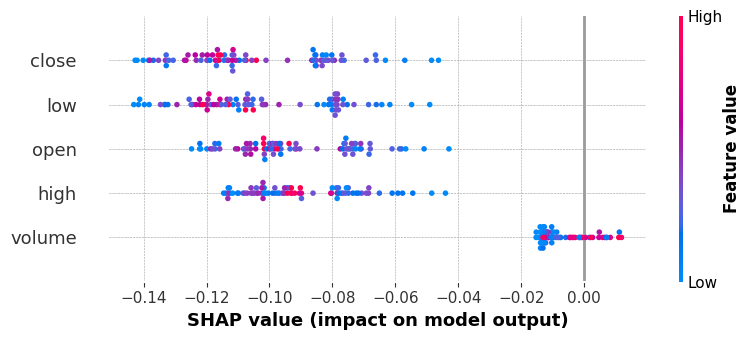

In [96]:
# Selecting a larger subset for SHAP
num_samples_for_shap = 126
X_subset_reshaped_2d = X_test_flat[:num_samples_for_shap]

# Reduce background samples (it was too large to run on my computer)
background_data_reduced = shap.kmeans(reshaped_X_train_flat, 10)  # using 10 clusters for reduced background data

# Initialize SHAP explainer with reduced background data
explainer = shap.KernelExplainer(model_predict, background_data_reduced)

# Computing SHAP values
shap_values = explainer.shap_values(X_subset_reshaped_2d)

# Debug: Print the new shape (added debugging because it was not showing all results among others.)
print("New SHAP values shape:", np.array(shap_values).shape)

# Reshaping SHAP values
shap_values_reshaped = np.array(shap_values).reshape(-1, window_size, 5)

# Debug: Print new reshaped shape
print("New reshaped SHAP values shape:", shap_values_reshaped.shape)

# Sum across timesteps to group by feature
shap_values_grouped = np.sum(shap_values_reshaped, axis=1)

# Debug: Print grouped shape
print("New grouped SHAP values shape:", shap_values_grouped.shape) 

# Extract corresponding feature values from multiple samples
X_subset_features = X_subset_reshaped_2d[:, :5]

# Debug: Print feature values shape
print("X_subset_features shape (for multiple samples):", X_subset_features.shape)

# Feature names without timestep indices
feature_names_grouped = ['open', 'high', 'low', 'close', 'volume']

# SHAP summary plot
shap.summary_plot(shap_values_grouped, X_subset_features, feature_names=feature_names_grouped)


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:53<00:00,  1.45it/s]


Type of SHAP values: <class 'numpy.ndarray'>
Length of SHAP values: 77
Shape of raw SHAP values: (77, 250)
Reshaped SHAP values shape: (77, 50, 5)
Averaged SHAP values shape: (50, 5)


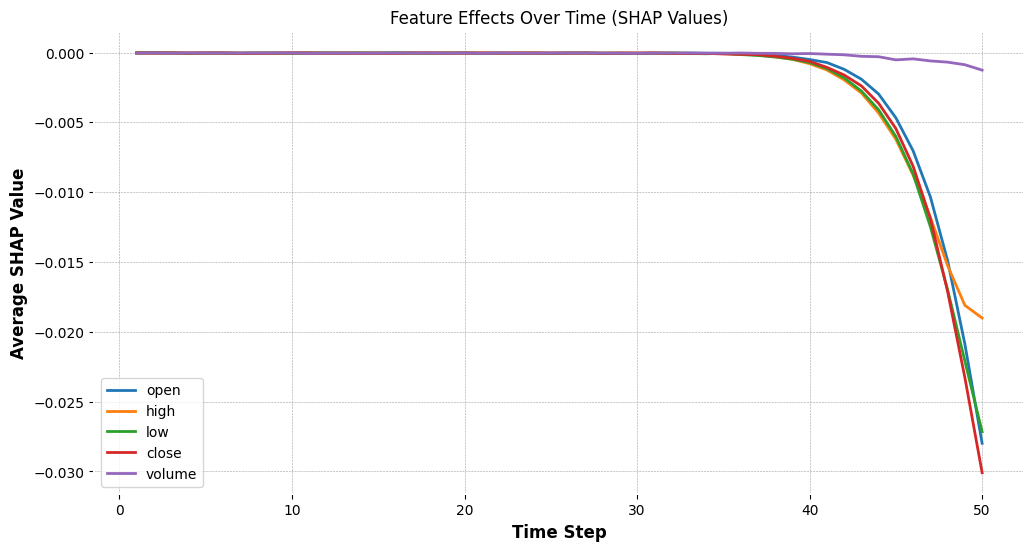

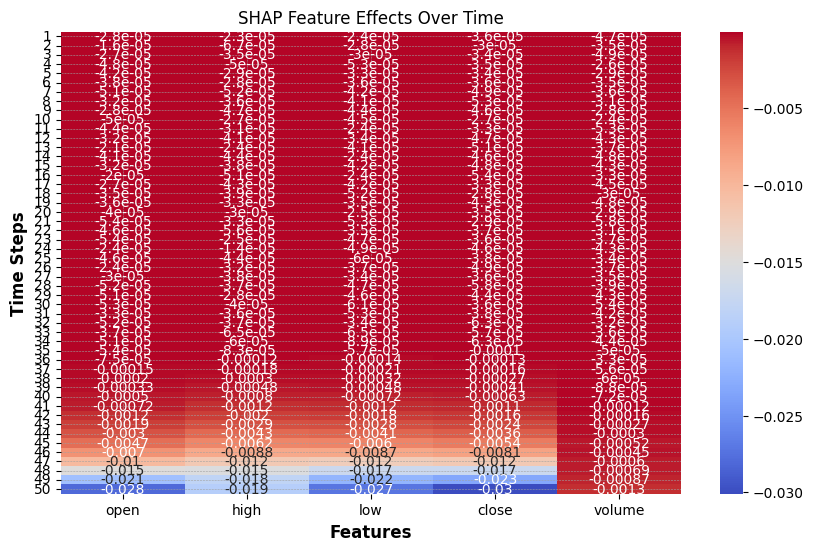

In [97]:
# Initializing SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, background_data_reshaped)

# using all available data
X_subset_reshaped_2d = X_test_flat[:100]  

# Compute SHAP values for test samples
shap_values = explainer.shap_values(X_subset_reshaped_2d)

# Debugging: Checking SHAP values structure
print(f"Type of SHAP values: {type(shap_values)}")
print(f"Length of SHAP values: {len(shap_values)}")
print(f"Shape of raw SHAP values: {np.array(shap_values).shape}")

# If SHAP values come as a list, extract first element
if isinstance(shap_values, list):
    shap_values_array = np.array(shap_values[0])  
else:
    shap_values_array = np.array(shap_values)

# determine the number of time steps
num_time_steps = X_subset_reshaped_2d.shape[1] // 5 

# Reshaping SHAP values
time_step_shap_effects = shap_values_array.reshape(len(X_subset_reshaped_2d), num_time_steps, 5)

# Verify shape (again, there were many bugs in the shaping.)
print(f"Reshaped SHAP values shape: {time_step_shap_effects.shape}")  # Expect (46, num_time_steps, 5)

# Average across all samples to see feature effects over time
time_step_shap_effects_avg = np.mean(time_step_shap_effects, axis=0)  

# Verify shape
print(f"Averaged SHAP values shape: {time_step_shap_effects_avg.shape}")  # Expect (num_time_steps, 5)

# Define time steps dynamically
time_steps = np.arange(1, num_time_steps + 1)

# Plotting SHAP values over time
plt.figure(figsize=(12, 6))
for i, feature in enumerate(['open', 'high', 'low', 'close', 'volume']):  
    plt.plot(time_steps, time_step_shap_effects_avg[:, i], label=feature)

plt.title("Feature Effects Over Time (SHAP Values)")
plt.xlabel("Time Step")
plt.ylabel("Average SHAP Value")
plt.legend()
plt.show()

# Generating Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(time_step_shap_effects_avg, cmap='coolwarm', annot=True, 
            xticklabels=['open', 'high', 'low', 'close', 'volume'], 
            yticklabels=time_steps)
plt.title("SHAP Feature Effects Over Time")
plt.xlabel("Features")
plt.ylabel("Time Steps")
plt.show()


Computing Integrated Gradients: 100%|█████████████████████████████████████████████████| 50/50 [00:00<00:00, 726.95it/s]


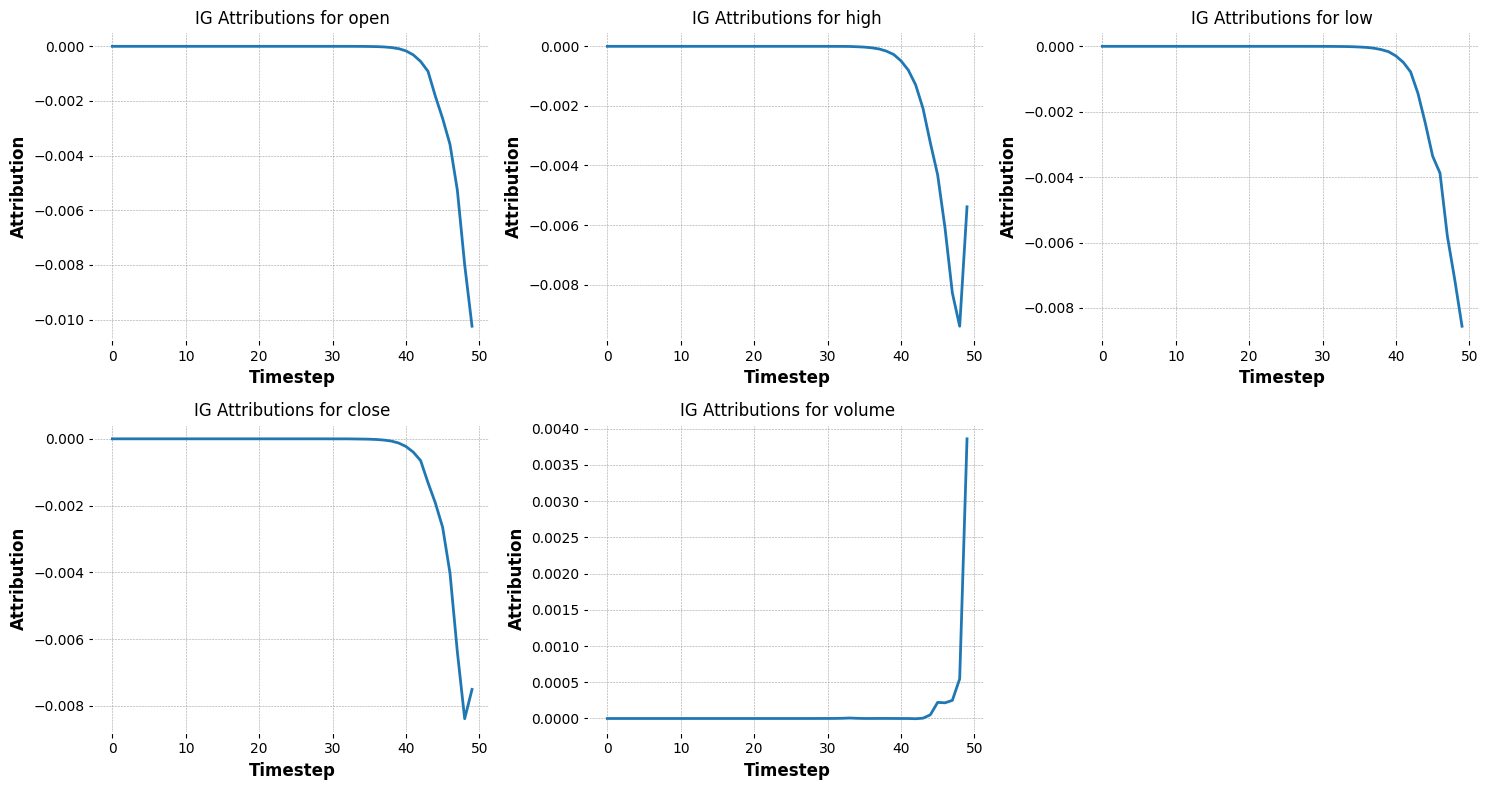

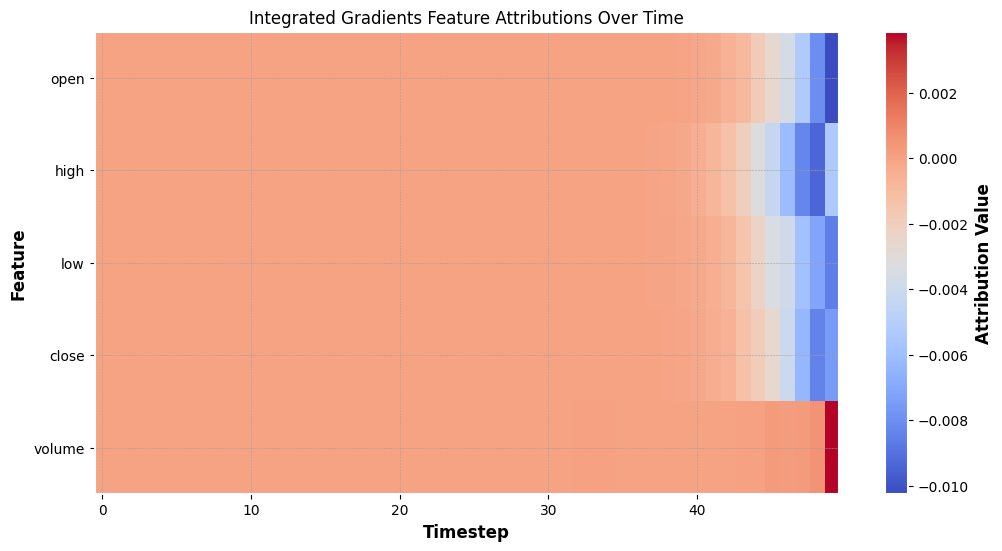

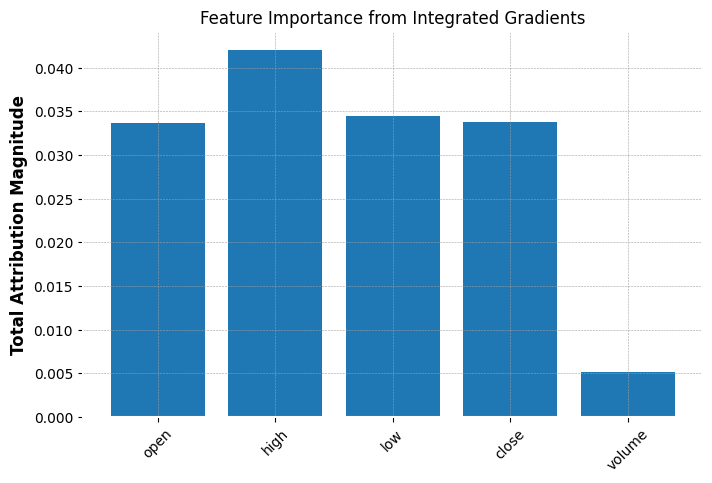

In [98]:
# Defining the Integrated Gradients function
def integrated_gradients(model, input_tensor, baseline=None, steps=50):
    
    # Setting the model to evaluation mode
    model.eval()
    
    # Using zeros baseline
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    
    # Ensuring we have batch dimension
    if len(input_tensor.shape) == 2:
        input_tensor = input_tensor.unsqueeze(0)
    if len(baseline.shape) == 2:
        baseline = baseline.unsqueeze(0)
    
    # Scaling the input and baseline to ensure they're in the same range
    input_tensor = (input_tensor - baseline)
    
    # Generating alphas
    alphas = torch.linspace(0, 1, steps)
    
    # Initializinug gradients
    gradients = 0
    
    # Computing gradients for each alpha
    for alpha in tqdm(alphas, desc="Computing Integrated Gradients"):
        # Interpolated input
        interpolated_input = baseline + alpha * input_tensor
        interpolated_input.requires_grad_(True)
        
        # Forward pass
        pred = model(interpolated_input)
        
        # Backward pass (computing gradients)
        pred.backward()
        
        # Adding gradients
        gradients += interpolated_input.grad
        
        # Clearing gradients
        interpolated_input.grad.zero_()
    
    # Computing integrated gradients
    ig = input_tensor * gradients / steps
    
    return ig

# Selecting a sample to explain
sample_idx = 0
sample_input = X_test_tensor[sample_idx].unsqueeze(0)

# Computing integrated gradients
ig_attributions = integrated_gradients(model, sample_input)

# Converting to numpy
ig_attributions = ig_attributions.detach().numpy().squeeze()

# Visualizing the attributions per feature over time
plt.figure(figsize=(15, 8))

features = ['open', 'high', 'low', 'close', 'volume']
timesteps = np.arange(window_size)

for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    plt.plot(timesteps, ig_attributions[:, i])
    plt.title(f'IG Attributions for {feature}')
    plt.xlabel('Timestep')
    plt.ylabel('Attribution')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Visualizing the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(ig_attributions.T, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Attribution Value')
plt.yticks(np.arange(len(features)), features)
plt.xlabel('Timestep')
plt.ylabel('Feature')
plt.title('Integrated Gradients Feature Attributions Over Time')
plt.show()

# Aggregating attributions by feature
feature_importances = np.sum(np.abs(ig_attributions), axis=0)

plt.figure(figsize=(8, 5))
plt.bar(features, feature_importances)
plt.title('Feature Importance from Integrated Gradients')
plt.ylabel('Total Attribution Magnitude')
plt.xticks(rotation=45)
plt.show()

[DEBUG] Input shape: torch.Size([1, 50, 5])
[DEBUG] LSTM output shape: torch.Size([1, 50, 64])
[DEBUG] Model output shape: torch.Size([1, 1])
[DEBUG] Gradients shape: torch.Size([1, 50, 5])


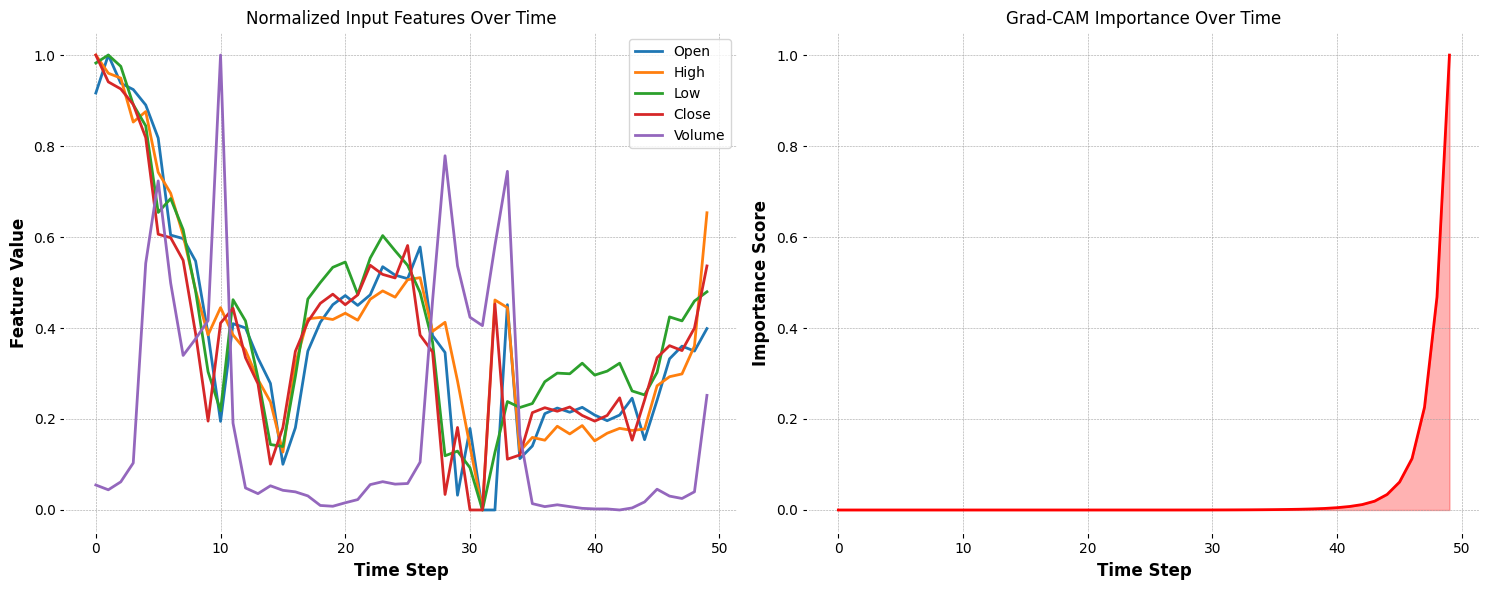

In [99]:
def normalize_input(input_tensor): #normalizing input tensor to [0,1] range per feature
    input_tensor = input_tensor.detach()  # Ensure that I am working with detached tensor
    min_val = input_tensor.min(dim=0, keepdim=True).values
    max_val = input_tensor.max(dim=0, keepdim=True).values
    return (input_tensor - min_val) / (max_val - min_val + 1e-10)

def lstm_grad_cam(model, input_tensor, target_class=None, debug_mode=False): # improved grad-cam implementation for LSTM
    # 1. Preparing the input
    input_tensor = input_tensor.clone().detach().unsqueeze(0).requires_grad_(True)
    if debug_mode:
        print(f"[DEBUG] Input shape: {input_tensor.shape}")

    # 2. Preparing the model
    model.eval()
    for param in model.parameters():
        param.requires_grad = True  # Ensure we can compute gradients

    # 3. Forward pass: getting the LSTM outputs and final prediction
    lstm_out, (hn, cn) = model.lstm(input_tensor)
    output = model.fc(hn[-1])  # Getting the final prediction
    
    if debug_mode:
        print(f"[DEBUG] LSTM output shape: {lstm_out.shape}")
        print(f"[DEBUG] Model output shape: {output.shape}")

    # 4. Handling the target class
    if target_class is None:
        target_class = output.argmax().item()
    target = torch.zeros_like(output)
    target[0, target_class] = 1

    # 5. Computing gradients with respect to LSTM outputs
    model.zero_grad()
    output.backward(gradient=target, retain_graph=True)
    
    # Getting gradients of output with respect to LSTM outputs
    gradients = input_tensor.grad
    if gradients is None:
        gradients = torch.autograd.grad(outputs=output, inputs=lstm_out,
                                     grad_outputs=target, retain_graph=True)[0]
    
    if debug_mode:
        print(f"[DEBUG] Gradients shape: {gradients.shape if gradients is not None else None}")

    # 6. Computing Grad-CAM
    if gradients is None:
        raise RuntimeError("Failed to compute gradients")
    
    # Pool gradients spatially (average over all features)
    alpha = gradients.mean(dim=-1, keepdim=True)
    
    # Weight the LSTM outputs by the importance it has
    gradcam = (lstm_out * alpha).sum(dim=-1)
    
    # Applying ReLU and normalize
    gradcam = torch.relu(gradcam)
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-10)
    
    return gradcam.squeeze(0).detach().cpu().numpy()

def visualize_gradcam(input_tensor, heatmap, feature_names): #improved visualization for LSTM grad-cam
    # Ensuring that the input is detached and converted to numpy
    input_tensor = input_tensor.detach().cpu().numpy() if torch.is_tensor(input_tensor) else input_tensor
    heatmap = heatmap.detach().cpu().numpy() if torch.is_tensor(heatmap) else heatmap
    
    # Normalizing the input
    input_tensor = normalize_input(torch.tensor(input_tensor)).numpy()
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Input features over time
    plt.subplot(1, 2, 1)
    for i, name in enumerate(feature_names):
        plt.plot(input_tensor[:, i], label=name)
    plt.title("Normalized Input Features Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Feature Value")
    plt.legend()
    
    # Plot 2: Grad-CAM heatmap
    plt.subplot(1, 2, 2)
    plt.plot(heatmap, color='red', linewidth=2)
    plt.fill_between(range(len(heatmap)), heatmap, alpha=0.3, color='red')
    plt.title("Grad-CAM Importance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Importance Score")
    
    plt.tight_layout()
    plt.show()

# Testing the implementation (again many errors occurred so this seemed best for me.)
if __name__ == "__main__":
    # Example usage with dummy data
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Creating a dummy model and data
    class LSTMModel(torch.nn.Module):
        def __init__(self, input_size=5, hidden_size=64, output_size=1):
            super().__init__()
            self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
            self.fc = torch.nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            lstm_out, (hn, cn) = self.lstm(x)
            return self.fc(hn[-1])
    
    model = LSTMModel()
    
    sample_input = X_test_tensor[0].clone()  # Getting one sample
    heatmap = lstm_grad_cam(model, sample_input, debug_mode=True)
    visualize_gradcam(sample_input, heatmap, features)

In [100]:
# same code as the first example, just using some changes, indicated in the comments.
file_path = 'ES_1hour_sample.csv'
df = pd.read_csv(file_path)

print(df.head())
print(df.tail())

prices = df['close'].values

def prepare_data_with_features(df, window_size):
    X = []
    y = []
    
    features = ['open', 'high', 'low', 'close', 'volume']
    
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)
        y.append(df['close'].iloc[i+window_size]) 
    
    return np.array(X), np.array(y)

train_size = int(len(prices) * 0.5)

train_prices = prices[train_size:]  # Now this will become the new training data
test_prices = prices[:train_size]   # Now this will become the new test data

window_size = 50

X_train, y_train = prepare_data_with_features(df[train_size:], window_size)  # Using the second half as training data
X_test, y_test = prepare_data_with_features(df[:train_size], window_size)    # Using the first half as testing data

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

batch_size = 32
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        pred = self.fc(self.dropout(hn[-1]))
        return pred

model = LSTMModel(input_size=5, hidden_layer_size=64, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 20
for epoch in range(num_epochs):
    model.train() 
    total_loss = 0 
    
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()

        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss / len(train_loader)}")

reshaped_feature_names = []
for t in range(1, window_size + 1):
    for feature in ['open', 'high', 'low', 'close', 'volume']:
        reshaped_feature_names.append(f"{feature}_{t}")


reshaped_X_train_flat = X_train_scaled.reshape(-1, window_size * 5)


print("Flattened X_train shape:", reshaped_X_train_flat.shape)


background_data_kmeans = shap.kmeans(reshaped_X_train_flat, 3) 

print("Background data shape from k-means:", background_data_kmeans.data.shape)

background_data_reshaped = background_data_kmeans.data.reshape(3, window_size * 5)

print("Reshaped background data shape:", background_data_reshaped.shape)

X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], window_size * 5) 

print("Reshaped test data shape:", X_test_flat.shape)

             timestamp     open     high      low    close  volume
0  2025-03-02 18:00:00  5967.50  5984.50  5964.25  5974.25   24096
1  2025-03-02 19:00:00  5974.50  5975.75  5947.00  5955.25   23919
2  2025-03-02 20:00:00  5955.25  5966.75  5951.50  5965.25   14393
3  2025-03-02 21:00:00  5965.25  5969.00  5959.75  5964.25    8750
4  2025-03-02 22:00:00  5964.25  5965.50  5957.50  5965.00    7737
               timestamp     open     high      low    close  volume
248  2025-03-17 12:00:00  5700.25  5714.50  5694.50  5707.75   63831
249  2025-03-17 13:00:00  5708.00  5736.50  5701.00  5733.50   67361
250  2025-03-17 14:00:00  5733.50  5759.75  5733.25  5754.50   80243
251  2025-03-17 15:00:00  5754.25  5755.75  5730.50  5732.75  147001
252  2025-03-17 16:00:00  5732.50  5733.75  5725.75  5731.75   41210
Epoch 1/20, Train Loss: 0.3202885389328003
Epoch 2/20, Train Loss: 0.26647694905598956
Epoch 3/20, Train Loss: 0.18509983023007712
Epoch 4/20, Train Loss: 0.13588436444600424
Epoch 5/2

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [01:28<00:00,  1.16s/it]


New SHAP values shape: (76, 250)
New reshaped SHAP values shape: (76, 50, 5)
New grouped SHAP values shape: (76, 5)
X_subset_features shape (for multiple samples): (76, 5)


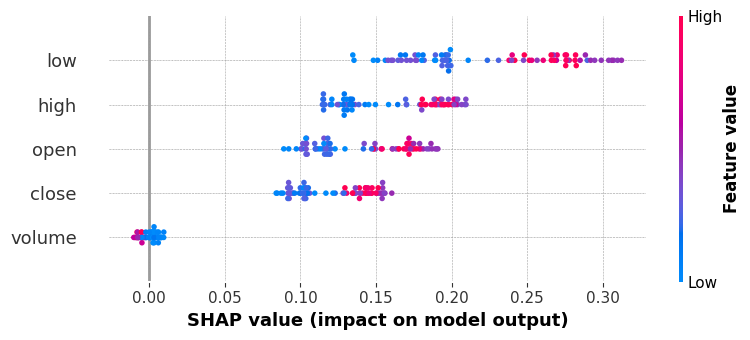

In [101]:
# functionally identical code like the first example, just for the other test/train data.

num_samples_for_shap = 126
X_subset_reshaped_2d = X_test_flat[:num_samples_for_shap]

background_data_reduced = shap.kmeans(reshaped_X_train_flat, 10)

explainer = shap.KernelExplainer(model_predict, background_data_reduced)

shap_values = explainer.shap_values(X_subset_reshaped_2d)
print("New SHAP values shape:", np.array(shap_values).shape)

shap_values_reshaped = np.array(shap_values).reshape(-1, window_size, 5)
print("New reshaped SHAP values shape:", shap_values_reshaped.shape)

shap_values_grouped = np.sum(shap_values_reshaped, axis=1)
print("New grouped SHAP values shape:", shap_values_grouped.shape)

X_subset_features = X_subset_reshaped_2d[:, :5]
print("X_subset_features shape (for multiple samples):", X_subset_features.shape) 

feature_names_grouped = ['open', 'high', 'low', 'close', 'volume']

shap.summary_plot(shap_values_grouped, X_subset_features, feature_names=feature_names_grouped)


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:54<00:00,  1.40it/s]


Type of SHAP values: <class 'numpy.ndarray'>
Length of SHAP values: 76
Shape of raw SHAP values: (76, 250)
Reshaped SHAP values shape: (76, 50, 5)
Averaged SHAP values shape: (50, 5)


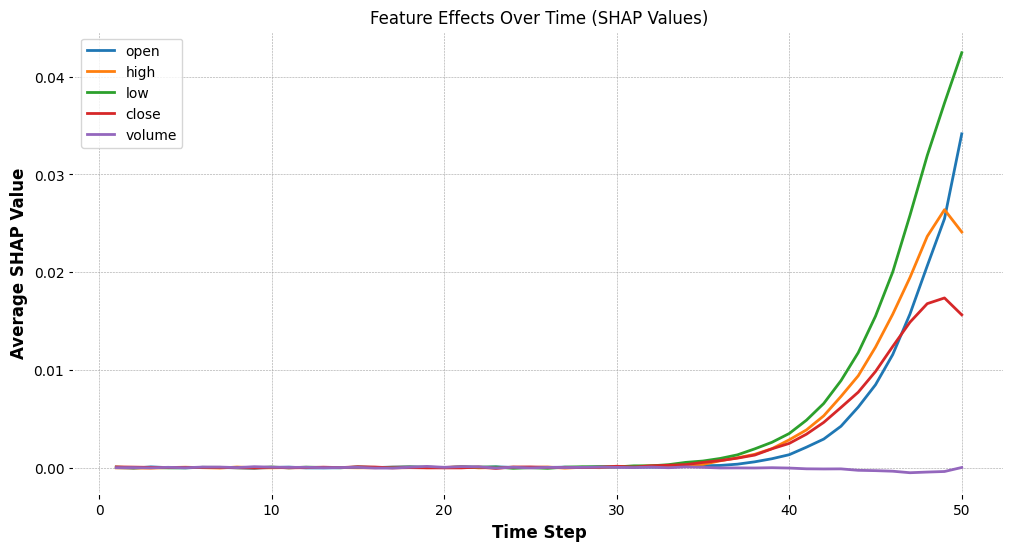

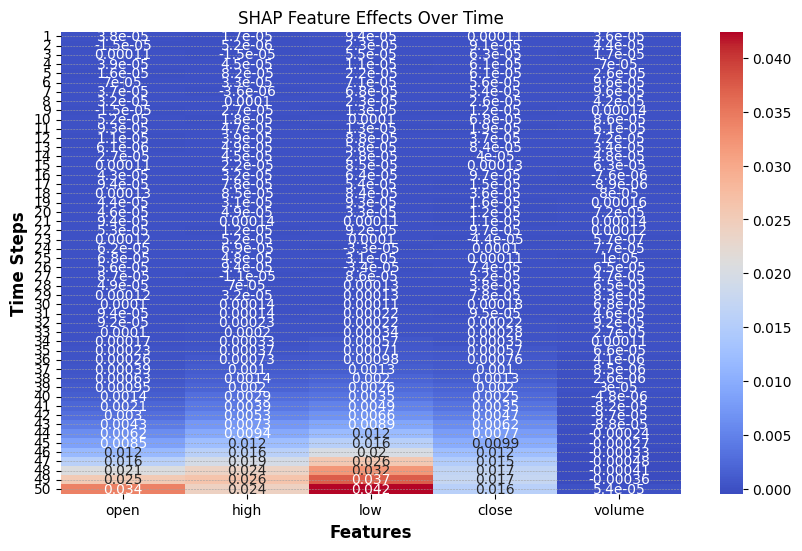

In [102]:
# functionally identical code like the first example, just for the other test/train data.

explainer = shap.KernelExplainer(model_predict, background_data_reshaped)

X_subset_reshaped_2d = X_test_flat[:116]  

shap_values = explainer.shap_values(X_subset_reshaped_2d)

print(f"Type of SHAP values: {type(shap_values)}")
print(f"Length of SHAP values: {len(shap_values)}")
print(f"Shape of raw SHAP values: {np.array(shap_values).shape}")

if isinstance(shap_values, list):
    shap_values_array = np.array(shap_values[0])  
else:
    shap_values_array = np.array(shap_values)

num_time_steps = X_subset_reshaped_2d.shape[1] // 5  

time_step_shap_effects = shap_values_array.reshape(len(X_subset_reshaped_2d), num_time_steps, 5)

print(f"Reshaped SHAP values shape: {time_step_shap_effects.shape}")

time_step_shap_effects_avg = np.mean(time_step_shap_effects, axis=0)  

print(f"Averaged SHAP values shape: {time_step_shap_effects_avg.shape}")

time_steps = np.arange(1, num_time_steps + 1)

plt.figure(figsize=(12, 6))
for i, feature in enumerate(['open', 'high', 'low', 'close', 'volume']):  
    plt.plot(time_steps, time_step_shap_effects_avg[:, i], label=feature)

plt.title("Feature Effects Over Time (SHAP Values)")
plt.xlabel("Time Step")
plt.ylabel("Average SHAP Value")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(time_step_shap_effects_avg, cmap='coolwarm', annot=True, 
            xticklabels=['open', 'high', 'low', 'close', 'volume'], 
            yticklabels=time_steps)
plt.title("SHAP Feature Effects Over Time")
plt.xlabel("Features")
plt.ylabel("Time Steps")
plt.show()


Computing Integrated Gradients: 100%|█████████████████████████████████████████████████| 50/50 [00:00<00:00, 539.07it/s]


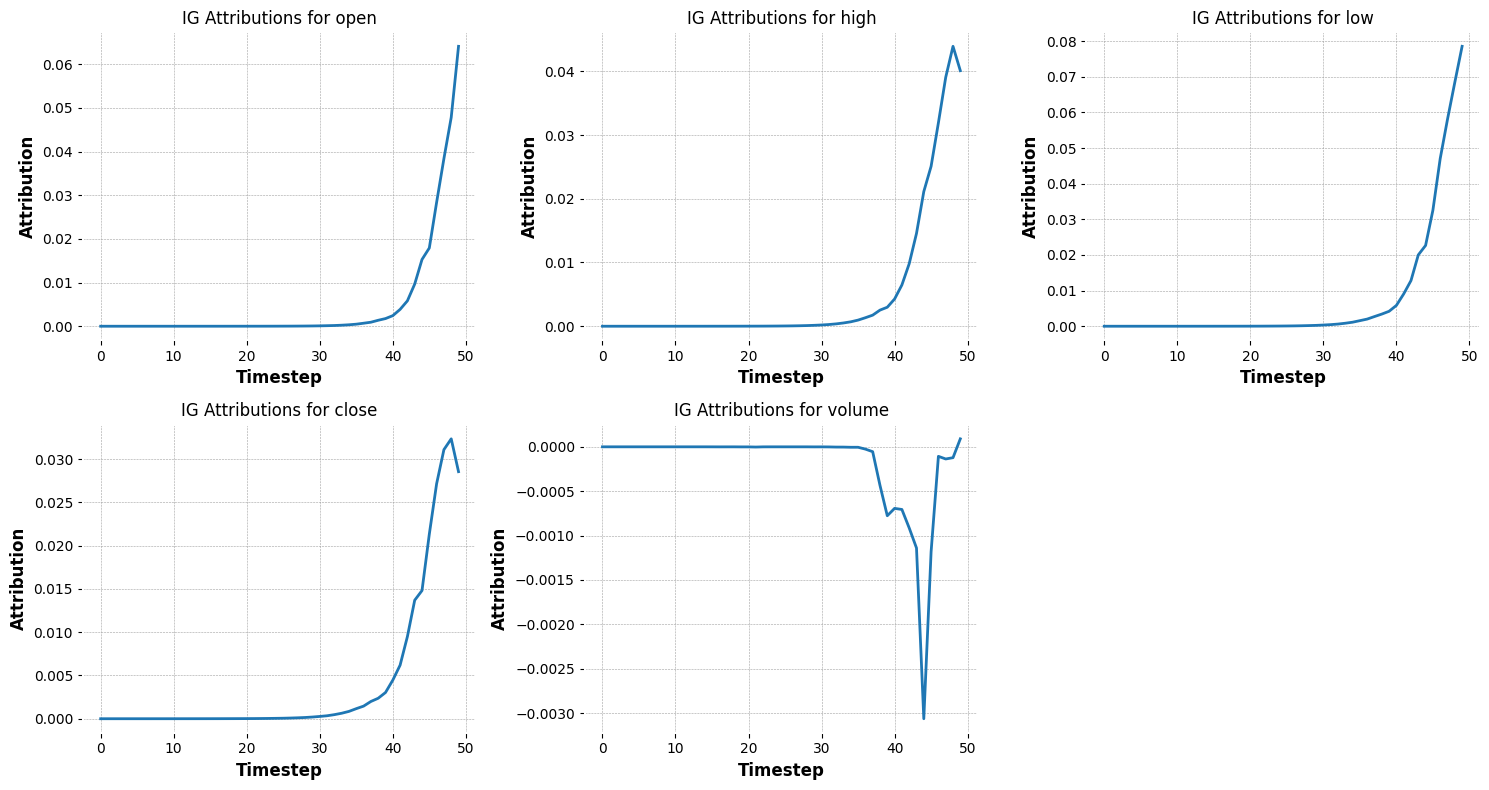

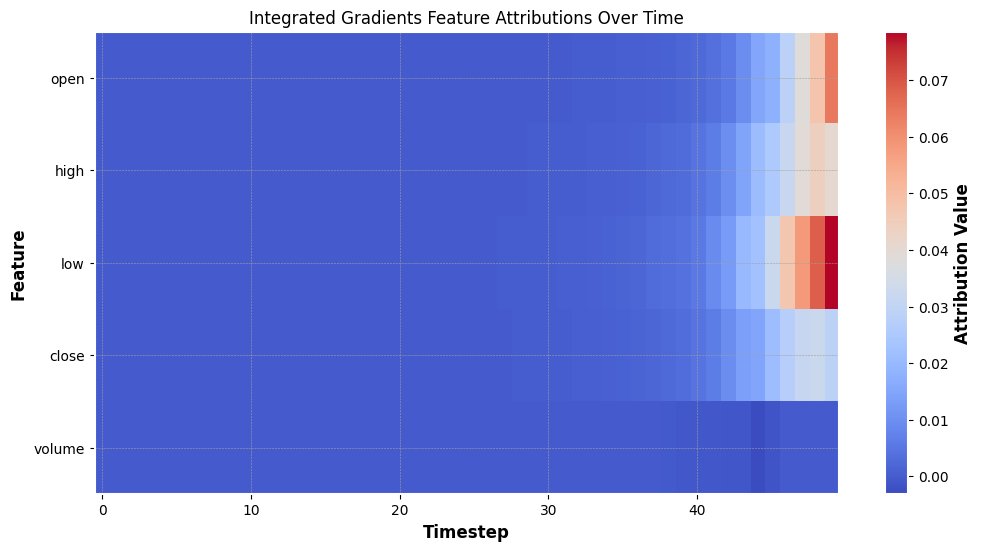

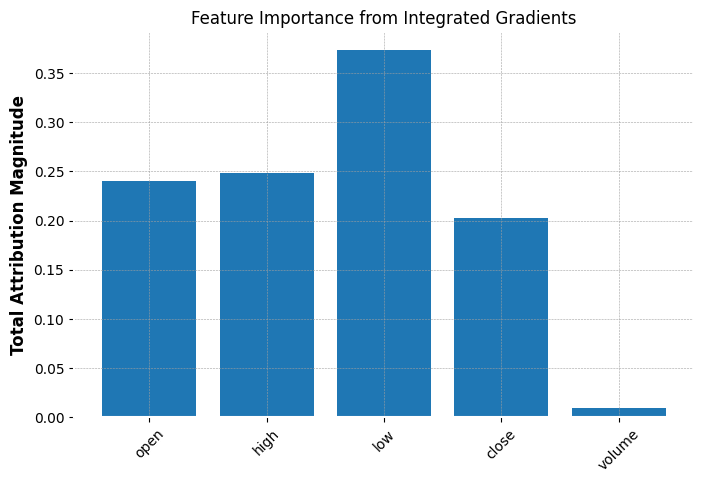

In [103]:
# functionally identical code like the first example, just for the other test/train data.

def integrated_gradients(model, input_tensor, baseline=None, steps=50):
    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    if len(input_tensor.shape) == 2:
        input_tensor = input_tensor.unsqueeze(0)
    if len(baseline.shape) == 2:
        baseline = baseline.unsqueeze(0)
    input_tensor = (input_tensor - baseline)
    alphas = torch.linspace(0, 1, steps)
    gradients = 0
    for alpha in tqdm(alphas, desc="Computing Integrated Gradients"):
        interpolated_input = baseline + alpha * input_tensor
        interpolated_input.requires_grad_(True)
        pred = model(interpolated_input)
        pred.backward()
        gradients += interpolated_input.grad
        interpolated_input.grad.zero_()
    ig = input_tensor * gradients / steps
    return ig

sample_idx = 0
sample_input = X_test_tensor[sample_idx].unsqueeze(0)
ig_attributions = integrated_gradients(model, sample_input)
ig_attributions = ig_attributions.detach().numpy().squeeze()

plt.figure(figsize=(15, 8))
features = ['open', 'high', 'low', 'close', 'volume']
timesteps = np.arange(window_size)

for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    plt.plot(timesteps, ig_attributions[:, i])
    plt.title(f'IG Attributions for {feature}')
    plt.xlabel('Timestep')
    plt.ylabel('Attribution')
    plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(ig_attributions.T, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Attribution Value')
plt.yticks(np.arange(len(features)), features)
plt.xlabel('Timestep')
plt.ylabel('Feature')
plt.title('Integrated Gradients Feature Attributions Over Time')
plt.show()

feature_importances = np.sum(np.abs(ig_attributions), axis=0)

plt.figure(figsize=(8, 5))
plt.bar(features, feature_importances)
plt.title('Feature Importance from Integrated Gradients')
plt.ylabel('Total Attribution Magnitude')
plt.xticks(rotation=45)
plt.show()


[DEBUG] Input shape: torch.Size([1, 50, 5])
[DEBUG] LSTM output shape: torch.Size([1, 50, 64])
[DEBUG] Model output shape: torch.Size([1, 1])
[DEBUG] Gradients shape: torch.Size([1, 50, 5])


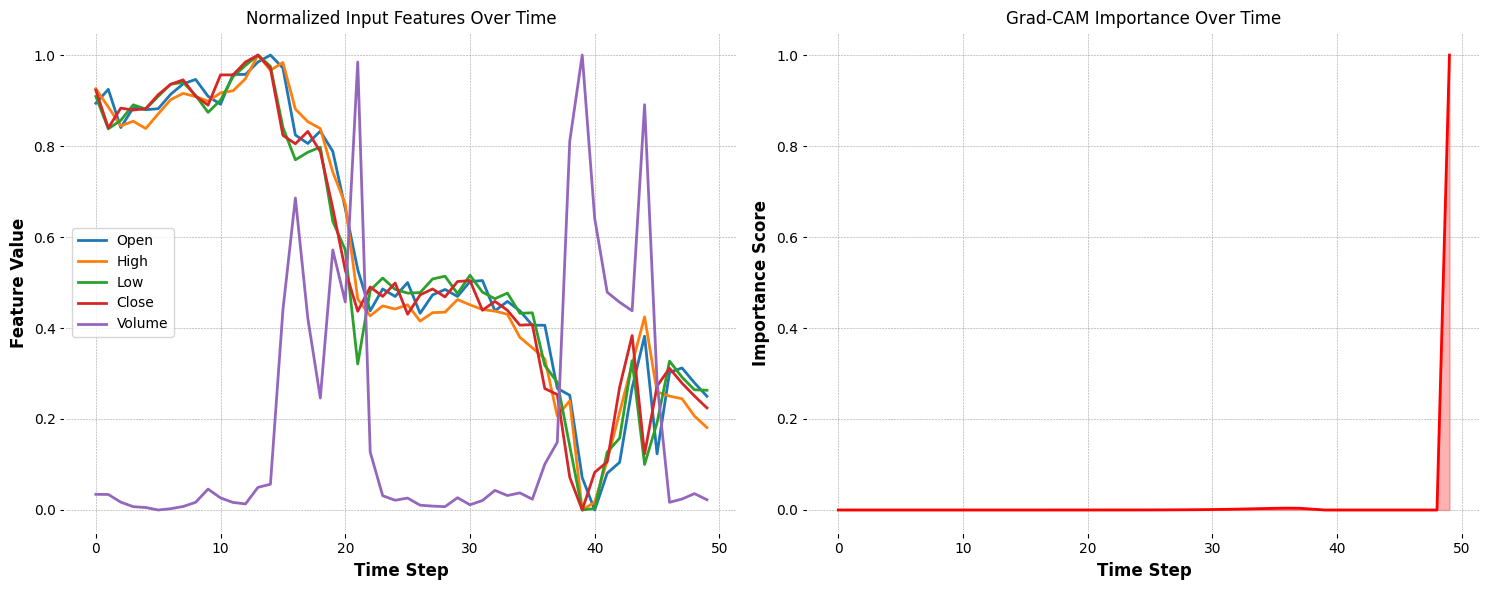

In [104]:
# functionally identical code like the first example, just for the other test/train data.

def normalize_input(input_tensor):
    input_tensor = input_tensor.detach()
    min_val = input_tensor.min(dim=0, keepdim=True).values
    max_val = input_tensor.max(dim=0, keepdim=True).values
    return (input_tensor - min_val) / (max_val - min_val + 1e-10)

def lstm_grad_cam(model, input_tensor, target_class=None, debug_mode=False):
    input_tensor = input_tensor.clone().detach().unsqueeze(0).requires_grad_(True)
    if debug_mode:
        print(f"[DEBUG] Input shape: {input_tensor.shape}")

    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    lstm_out, (hn, cn) = model.lstm(input_tensor)
    output = model.fc(hn[-1])

    if debug_mode:
        print(f"[DEBUG] LSTM output shape: {lstm_out.shape}")
        print(f"[DEBUG] Model output shape: {output.shape}")

    if target_class is None:
        target_class = output.argmax().item()
    target = torch.zeros_like(output)
    target[0, target_class] = 1

    model.zero_grad()
    output.backward(gradient=target, retain_graph=True)

    gradients = input_tensor.grad
    if gradients is None:
        gradients = torch.autograd.grad(outputs=output, inputs=lstm_out,
                                     grad_outputs=target, retain_graph=True)[0]

    if debug_mode:
        print(f"[DEBUG] Gradients shape: {gradients.shape if gradients is not None else None}")

    if gradients is None:
        raise RuntimeError("Failed to compute gradients")

    alpha = gradients.mean(dim=-1, keepdim=True)

    gradcam = (lstm_out * alpha).sum(dim=-1)

    gradcam = torch.relu(gradcam)
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-10)

    return gradcam.squeeze(0).detach().cpu().numpy()

def visualize_gradcam(input_tensor, heatmap, feature_names):
    input_tensor = input_tensor.detach().cpu().numpy() if torch.is_tensor(input_tensor) else input_tensor
    heatmap = heatmap.detach().cpu().numpy() if torch.is_tensor(heatmap) else heatmap

    input_tensor = normalize_input(torch.tensor(input_tensor)).numpy()

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    for i, name in enumerate(feature_names):
        plt.plot(input_tensor[:, i], label=name)
    plt.title("Normalized Input Features Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Feature Value")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(heatmap, color='red', linewidth=2)
    plt.fill_between(range(len(heatmap)), heatmap, alpha=0.3, color='red')
    plt.title("Grad-CAM Importance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Importance Score")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    features = ['Open', 'High', 'Low', 'Close', 'Volume']

    class LSTMModel(torch.nn.Module):
        def __init__(self, input_size=5, hidden_size=64, output_size=1):
            super().__init__()
            self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
            self.fc = torch.nn.Linear(hidden_size, output_size)

        def forward(self, x):
            lstm_out, (hn, cn) = self.lstm(x)
            return self.fc(hn[-1])

    model = LSTMModel()

    sample_input = X_test_tensor[0].clone()
    heatmap = lstm_grad_cam(model, sample_input, debug_mode=True)
    visualize_gradcam(sample_input, heatmap, features)
